In [151]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from model import *
from generate_data import *
from smc import *

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

Define the dimensions and constants of the system we're working with:

In [113]:
n_heads = 5

env = gym.make('Pendulum-v0')
ob0 = env.reset()
dataGen = DataGenerator(env)
param_vec = dataGen.generate_param_vec(n_heads)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [146]:
param_vec

[0.5713512443149343,
 1.4518835370296088,
 1.2132747928714545,
 1.4712082814587335,
 0.5119095001979941]

In [114]:
x_dim = ob0.size
u_dim = dataGen.sample_action().size

layer_sizes = [32,32]

lr = 2e-4
beta1 = 0.9

batch_size = 50
N = 500

In [112]:
x_dim

2

Set up the tensorflow graph

In [116]:
dyn_model = MultiHeadDynModel(x_dim, u_dim, layer_sizes, n_heads)
dyn_model.build_model()

Generate Data

In [117]:
x_data = np.zeros([N*n_heads, x_dim])
u_data = np.zeros([N*n_heads, u_dim])
xp_data = np.zeros([N*n_heads, x_dim])
ind_data = np.zeros([N*n_heads], dtype='int32')

for i, (m,p,x,u,xp) in enumerate( dataGen.do_n_steps(N, param_vec) ):
    x_data[i,:] = x
    u_data[i,:] = u
    xp_data[i,:] = xp
    ind_data[i] = m

# Train
Run and train the model on the data:

In [118]:
dyn_model.init()

In [120]:
dyn_model.train(x_data, u_data, xp_data, ind_data)
dyn_model.save()

Final Loss:  0.0410677


# Test

In [167]:
bf = BayesianFilter(param_vec,dyn_model)

w_hist = np.zeros([50, n_heads])
for j in range(50):
    mu,cov = bf.step(x_data[j,:],u_data[j,:],xp_data[j,:])
    w_hist[j,:] = bf.w

In [168]:
print(w_hist)

[[  4.96166865e-01   1.26134191e-02   2.21921484e-02   4.21293081e-03
    4.64814637e-01]
 [  5.15744848e-01   2.30395765e-04   1.12080124e-03   7.89413532e-05
    4.82825014e-01]
 [  5.19402055e-01   2.54711303e-04   1.20078118e-03   8.24867060e-05
    4.79059966e-01]
 [  5.18761770e-01   4.50220715e-05   4.36888462e-04   2.03810679e-05
    4.80735938e-01]
 [  5.27033996e-01   4.04277895e-07   2.27112870e-05   3.50313508e-07
    4.72942538e-01]
 [  5.19291798e-01   3.79058642e-07   1.99027552e-05   3.07632901e-07
    4.80687613e-01]
 [  5.43599565e-01   1.96470101e-07   1.10965466e-05   1.46549424e-07
    4.56388996e-01]
 [  5.53482557e-01   6.98266850e-08   7.15645849e-06   6.41321394e-08
    4.46510152e-01]
 [  5.68244347e-01   1.43280334e-08   2.73802991e-06   1.27739720e-08
    4.31752888e-01]
 [  5.82070114e-01   1.07546102e-08   2.47396490e-06   1.01373465e-08
    4.17927391e-01]
 [  5.77125961e-01   1.01121916e-08   2.18736615e-06   9.23915720e-09
    4.22871832e-01]
 [  6.4255

In [171]:
smc = SMCFilter(param_vec, dyn_model)

mean_alpha_hist = np.zeros([50, n_heads])
for j in range(50):
    mu,cov = smc.step(x_data[j,:],u_data[j,:],xp_data[j,:])
    mean_alpha_hist[j,:] = smc.mean_alpha
    print(smc.mean_alpha)

[ 0.31758485  0.07070421  0.13351906  0.1557611   0.32793717]
[ 0.3041802   0.02336938  0.11910866  0.07869534  0.48127504]
[ 0.24587475  0.0125813   0.18364115  0.09091116  0.46937977]
[ 0.27051779 -0.00148525  0.13466435  0.07904692  0.52287439]
[ 0.43167588 -0.00364271  0.10046601  0.0239366   0.45347327]
[ 0.4980421  -0.00600478  0.08283458  0.02747496  0.40496875]
[ 0.57192831 -0.00765882  0.08177069  0.01879951  0.34094348]
[ 0.65724443 -0.01412963  0.06542768  0.00403764  0.28900988]
[ 0.67473298 -0.00635078  0.0249537   0.0032951   0.30692229]
[ 0.67267504 -0.00726053  0.02491468  0.00269169  0.30996831]
[ 0.66799043 -0.00642699  0.0273184  -0.00205963  0.31598174]
[ 0.65836848 -0.00841141  0.01835307 -0.00444192  0.33917698]
[ 0.60892176 -0.00730842  0.0253669  -0.00474816  0.37675136]
[ 0.63013521 -0.00902688  0.02206556 -0.00444613  0.36417845]
[ 0.6427055  -0.01159197  0.01611149 -0.00478927  0.3612647 ]
[ 0.6559123  -0.01804365  0.01783164 -0.00665304  0.3531272 ]
[ 0.6732

## Test filtering on newly generated data

In [176]:
param_vec_test = dataGen.generate_param_vec(1)
N_test = 200
x_test = np.zeros([N_test, x_dim])
u_test = np.zeros([N_test, u_dim])
xp_test = np.zeros([N_test, x_dim])
ind_test = np.zeros([N_test], dtype='int32')

for i, (m,p,x,u,xp) in enumerate( dataGen.do_n_steps(N_test, param_vec_test) ):
    x_test[i,:] = x
    u_test[i,:] = u
    xp_test[i,:] = xp
    ind_test[i] = m
    
print('Test mass is:', param_vec_test[0])
print('Training parameters:', param_vec)

Test mass is: 1.4205392130966215
Training parameters: [0.5713512443149343, 1.4518835370296088, 1.2132747928714545, 1.4712082814587335, 0.5119095001979941]


In [179]:
smc = SMCFilter(param_vec, dyn_model)

mean_alpha_hist = np.zeros([50, n_heads])
for j in range(50):
    mu,cov = smc.step(x_test[j,:],u_test[j,:],xp_test[j,:])
    mean_alpha_hist[j,:] = smc.mean_alpha
    print(smc.mean_alpha)

[ 0.25559458  0.2162892   0.23991698  0.18219251  0.09993788]
[ 0.22222737  0.26269243  0.17363061  0.26387515  0.06887063]
[ 0.18277046  0.31574065  0.21527336  0.25319437  0.02361848]
[ 0.07166431  0.294594    0.2736654   0.34661367  0.00988979]
[ 0.02901749  0.26611027  0.34129854  0.35397566  0.00400432]
[ 0.03844213  0.29182518  0.29917541  0.36964922  0.00519459]
[ 0.07485064  0.29914115  0.204359    0.42038321  0.00531588]
[ 0.09061074  0.37026912  0.13433532  0.40183517  0.00499593]
[ 0.08909711  0.39334633  0.11732144  0.39414773  0.00553109]
[ 0.07787286  0.41371515  0.07192492  0.42651482  0.0110755 ]
[ 0.02593886  0.36697851  0.13655067  0.4570585   0.01405337]
[ 0.03285892  0.27565093  0.16151161  0.51424446  0.01341254]
[ 0.05854487  0.23525186  0.13137521  0.557798    0.01431112]
[ 0.03654314  0.25744731  0.1264025   0.56719157  0.01339643]
[ 0.03881605  0.21507681  0.19582944  0.53460491  0.01324986]
[ 0.03140906  0.24635669  0.13155195  0.56678305  0.0167058 ]
[ 0.0169

# Old toy data:

Generate some testing data

In [43]:
x_test = np.random.randn(200).reshape([100,2])
u_test = np.zeros([100,1])
y1_test = y1(x_test)
y2_test = y2(x_test)

In [49]:
x_pred_test = dyn_model.predict(x_test, u_test)

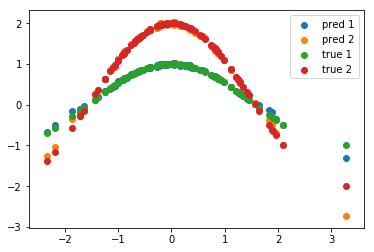

In [51]:
plt.figure()
plt.scatter(x_test[:,0], x_pred_test[0,:,0], label="pred 1")
plt.scatter(x_test[:,0], x_pred_test[1,:,0], label="pred 2")
plt.scatter(x_test[:,0], y1_test[:,0], label="true 1")
plt.scatter(x_test[:,0], y2_test[:,0], label="true 2")
plt.legend()
plt.show()

In [15]:
x_data = np.random.randn(200).reshape([100,2])
u_data = np.zeros([100,1])
y1 = lambda x_data: np.stack([np.cos(x_data[:,0]), np.sin(x_data[:,1])], axis=1)
y2 = lambda x_data: np.stack([2*np.cos(x_data[:,0]), np.sin(x_data[:,1])], axis=1)
# y1 = lambda x_data: x_data+1
# y2 = lambda x_data: 2*x_data
y1_data = y1(x_data) 
y2_data = y2(x_data)

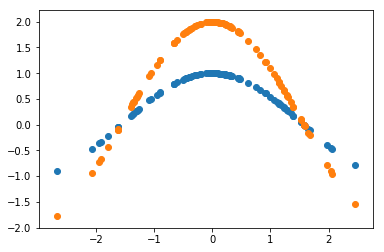

In [16]:
plt.figure()
plt.scatter(x_data[:,0], y1_data[:,0])
plt.scatter(x_data[:,0], y2_data[:,0])
plt.show()

In [31]:
x_input = np.concatenate([x_data, x_data])
u_input = np.zeros([200,1])
xp_input = np.concatenate([y1_data, y2_data])
ind_input = np.concatenate([np.zeros(100, dtype='int32'), np.ones(100,dtype='int32')]) #.reshape([200,1])
N = 200